In [ ]:
class Task:
    def __init__(self, id, parts, CT, preced_list, forbid_list):
        self.id = id
        self.parts = parts
        self.CT = CT
        self.preced_list = preced_list
        self.forbid_list = forbid_list
        self.clusterTasksID = []

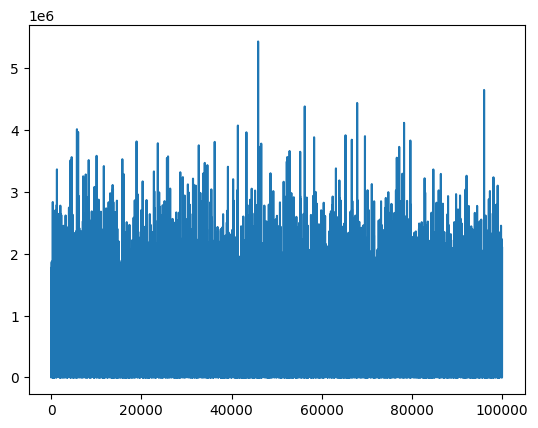

In [4]:
import matplotlib.pyplot as plt
import random
import plotly
l = []
for i in range(100000):
    l.append(random.expovariate(1/(3600*24*5)))

plt.plot(l)

3500
[17760.528880548787, 17593.583933005462, 17052.40093559031, 17593.22617908678, 17486.29681748897, 17150.041945231795, 17418.878901797423, 17142.319956226267, 17227.999118889486, 17777.53988128177, 17646.46586642028, 17299.20093724005, 17907.096784280733, 17364.64337821076, 16860.712315497265, 17414.808854993324, 17777.920928584426, 17630.687822662294, 16916.662663564937, 17039.769025264617, 18369.13375800776, 17423.83953772986, 17608.981851750403, 17605.312925659317, 17614.43175521449, 17422.137639207278, 17493.34044921068, 17646.305609307357, 17247.390019050934, 17500.035546092375, 17561.742712660944, 17524.3683252216, 17525.93952978486, 17255.320086084816, 17214.17627735677, 17938.640176337172, 17436.437269606635, 17373.782475349046, 18005.611381210678, 17052.866554642198, 17693.131891482204, 17422.29619911181, 17268.29897869539, 17372.818676074945, 17342.733684995448, 16983.015912950435, 17438.946709977878, 17470.98525619139, 17618.232633815147, 17779.830038655058, 17498.948743

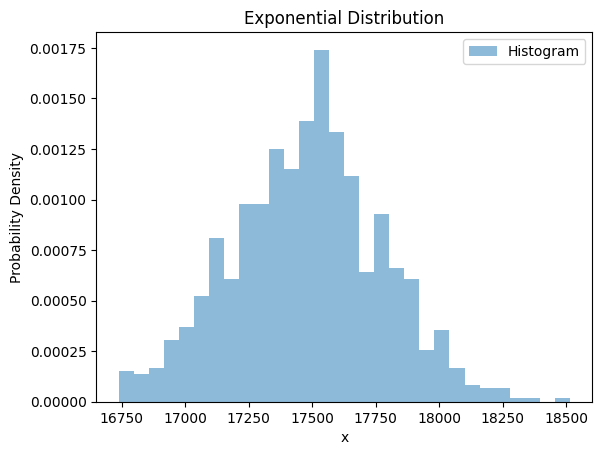

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, weibull_min

# Parameters
lam = 3500 # Rate parameter

# Generate random values
random_values = [random.expovariate(1/lam) for _ in range(1000)]
scale_parameter = lam 
print(scale_parameter)



random_values = [random.gammavariate(5, lam) for _ in range(1000)]

print(random_values)
# Calculate probability density function (PDF)
x = np.linspace(0, lam*5, 1000)
pdf =(1/lam)*expon.pdf(x, scale=1/lam, loc=lam)
print(x)

w_pdf = weibull_min.pdf(x, 5, scale=scale_parameter) 

# Plot histogram of generated random values
plt.hist(random_values, bins=30, density=True, alpha=0.5, label='Histogram')

# Plot the probability density function (PDF)
#plt.plot(x, w_pdf, 'r', label='PDF')

plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Exponential Distribution')
plt.legend()
plt.show()

In [ ]:
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
class QLearning:

    def __init__(self, n_episodes, Tasks, targetCT, tolerance):
        self.Tasks = Tasks
        self.target = targetCT
        self.tolerance = tolerance
        self.solution = []
        self.session_rewards = []
        self.n_episodes = n_episodes

    def step(self, action):
        done = False
        new_state = action
        self.solution.append(new_state)

        if len(self.solution) == len(self.Tasks):
            done = True
        return new_state, done

    def split(self, a, n):
        k, m = divmod(len(a), n)
        return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

    def precedence_graph(self):
        preced_graph = []

        # No Precedence Restrictions
        preced_graph.append([task for task in self.Tasks if not task.preced_list])
        for task in self.Tasks:
            # A precedence restriction with one of the first group
            for preced_task in task.preced_list:
                if preced_task in preced_graph:
                    preced_graph.append(task)

    def get_nworkstations(self):
        total_ct = 0
        ct_WS = [0]

        for i in self.solution:
          if ct_WS[-1]+float(self.Tasks[i].CT) > (1+self.tolerance)*(self.target / 2):
            ct_WS.append(float(self.Tasks[i].CT))
          else:
            ct_WS[-1]+=float(self.Tasks[i].CT)

        return len(ct_WS), ct_WS



    def objectiveR2(self):
        """
        Reward = -1 * (Number of Workstations Used) * (Number of Tasks Completed)
        This reward function takes into account both the number of tasks completed and the number of workstations used up to
        the current time. By multiplying the number of tasks completed with the negative of the number of workstations used,
        the reward function encourages the agent to complete as many tasks as possible while minimizing the number of workstations
        used.
        The partial reward can be calculated at each step of the assembly process, after each task is completed. The agent can
        then use this partial reward to update its policy and choose the next task to be completed based on the updated policy.

        Note that this partial reward function assumes that all tasks have the same complexity and require the same amount of time and resources. If this is not the case, you may need to modify the reward function to take into account the specific characteristics of each task.
        """
        if len(self.solution) == len(self.Tasks):
          n, CTs = self.get_nworkstations()
          m, CTsWorkers = self.estimate_WC()

          cost_empty_workstation = -10 if n % 2 == 0 else 10

          reward =-n*np.var(CTs)-m*np.var(CTsWorkers)-cost_empty_workstation
          #reward =-n*np.var(CTs)-m*np.var(CTsWorkers)-cost_empty_workstation

        else:
          reward = -10000 #Sequence infeasible

        #reward = (-n-n*np.std(CTs)-m*np.std(CTsWorkers)+self.cluster_reward()+self.check_precedence()+self.check_forbid())*len(self.solution)
        #reward = (-n-m+self.cluster_reward()+self.check_forbid()+self.check_precedence()+cost_empty_workstation)*len(self.solution)
        #reward = (-n-m+self.check_forbid())*len(self.solution)
        return reward


    def estimate_WC(self):
        n_workers = 1
        total_ct = 0
        parts_done = []
        ct_Workers = []
        for i in self.solution:
            total_ct += sum([float(part.duration) for part in self.Tasks[i].parts if part not in parts_done])
            total_ct += sum([3 for part in self.Tasks[i].parts if part in parts_done])
            for p in self.Tasks[i].parts:
                parts_done.append(p)

            if total_ct >= self.target:
                n_workers += 1
                ct_Workers.append(total_ct)
                total_ct = 0
        return n_workers, ct_Workers

    def sequence_to_scenario(self, indiv):
      Tasks_ID = [task.id for task in Tasks]

      total_ct = 0
      groups = []
      group = []
      for i in indiv:
          total_ct += float(self.Tasks[i].CT)
          group.append(i)
          if total_ct >= (1+self.tolerance)*(self.target / 2):
              groups.append(group.copy())
              total_ct = 0
              group=[]

      if total_ct > 0:
        if total_ct <= 0.3*(self.target / 2):
          groups[-1] = groups[-1] + group
        else:
          groups.append(group.copy())

      print(groups)
      scenario = [0 for i in range(len(Tasks_ID))]
      for i in range(len(groups)):
        for j in groups[i]:
          scenario[j] = i+1
      return scenario

    def sequence_to_scenario2(self, ant, final=False):
      total_ct = 0
      scenario = [0 for i in range(len(ant))]
      n_workstations = 1
      for i in ant:
            total_ct += float(self.Tasks[i].CT)
            if total_ct >= (self.target / 2):
                n_workstations += 1
                total_ct = 0
            scenario[i] = n_workstations

      return scenario

    def update_feasible_actions(self, state, actions):
        '''
        The only restriction is that a certain node x is not allowed to be vis-ited unless all the predecessor nodes are visited prior to n.
        '''

        # We remove last action from the possible actions of next step
        new_actions = list(actions).copy()

        new_actions.remove(state)
        # We add all new possible actions to it now (tasks that get now unlocked)
        Tasks_ID = [task.id for task in self.Tasks]

        new_unlocked = [self.Tasks.index(task) for task in self.Tasks if (
                    all(Tasks_ID.index(item) in self.solution for item in task.preced_list) and self.Tasks.index(
                task) not in self.solution and self.Tasks.index(task) not in new_actions)]
        for task_ind in new_unlocked:
            new_actions.append(task_ind)

        return new_actions

    def cluster_reward(self):

      if self.solution[-1] in self.prefered_actions(self.solution[-2]) or self.solution[-2] in self.prefered_actions(self.solution[-1]):
          return 100
      else:
        return -10

    def get_feasible_actions(self, state):
      new_actions = []
      Tasks_ID = [task.id for task in Tasks]

      new_unlocked = [self.Tasks.index(task) for task in self.Tasks if (
                  all(Tasks_ID.index(item) in self.solution for item in task.preced_list) and (self.Tasks.index(task) not in self.solution))]
      print(new_unlocked)
      for task_ind in new_unlocked:
          new_actions.append(task_ind)

      return new_actions

    def prefered_actions(self, state):
      prefered_tasks = list(self.Tasks[state].clusterTasksID).copy()
      return prefered_tasks

    def get_prefered_actions(self, state):

      prefered_tasks = list(self.Tasks[state].clusterTasksID).copy()
      for ind in prefered_tasks:
        if ind in self.solution:
          prefered_tasks.remove(ind)


      return prefered_tasks

    def check_precedence(self):
      Tasks_ID = [task.id for task in Tasks]
      if self.Tasks[self.solution[-1]].preced_list != []:
        if not all(Tasks_ID.index(item) in self.solution[:-1] for item in self.Tasks[self.solution[-1]].preced_list):

          return -100
        else:
          return 100
      else:
        return 0

    def check_forbid(self):
      Tasks_ID = [task.id for task in Tasks]

      total_ct = 0
      groups = []
      group = []
      for i in self.solution:
          total_ct += float(self.Tasks[i].CT)
          group.append(i)
          if total_ct >= (self.target / 2):
              groups.append(group.copy())
              total_ct = 0
              group=[]

      groups.append(group.copy())

      if self.Tasks[self.solution[-1]].forbid_list != []:
        for i in range(len(groups)):
          if self.solution[-1] in groups[i]:
            if all(Tasks_ID.index(item) not in groups[i] for item in self.Tasks[self.solution[-1]].forbid_list):
              return 10
            else:
              return -10
      else:
        return 0


    def check_forbid_full(self, indiv):
      Tasks_ID = [task.id for task in Tasks]

      total_ct = 0
      groups = []
      group = []
      for i in indiv:
          total_ct += float(self.Tasks[i].CT)
          group.append(i)
          if total_ct >= (self.target / 2):
              groups.append(group.copy())
              total_ct = 0
              group=[]

      groups.append(group.copy())
      j=0
      for ind in indiv:
        if self.Tasks[ind].forbid_list != []:
          for i in range(len(groups)):
            if ind in groups[i]:
              if not all(Tasks_ID.index(item) not in groups[i] for item in self.Tasks[ind].forbid_list):
                j+=1
      return j

    def check_precedence_full_sequence(self):
      Tasks_ID = [task.id for task in Tasks]
      j=0
      for i in range(len(self.solution)-1):
        if self.Tasks[self.solution[i+1]].preced_list != []:
          if not all(Tasks_ID.index(item) in self.solution[:i+1] for item in self.Tasks[self.solution[i+1]].preced_list):
            j+=1
      return j

    def check_precedence_final(self, candidate):
      Tasks_ID = [task.id for task in Tasks]
      j=0
      for i in range(len(candidate)-1):
        if self.Tasks[candidate[i+1]].preced_list != []:
          if not all(Tasks_ID.index(item) in candidate[:i+1] for item in self.Tasks[candidate[i+1]].preced_list):
            j+=1
      return j



    def train(self, n_episodes=3000, exploration_prob=1, gamma=0.5, lr=0.001):

        number_workstations_per_episode = []
        exploration_decreasing_decay = 0.01
        min_exploration_prob = 0.1
        max_workstations = np.sum([float(t.CT) for t in self.Tasks])//self.target + 5
        max_workers = max_workstations
        actions = range(len(self.Tasks))
        states = range(len(self.Tasks))

        q_table = np.zeros((len(states), len(actions)))
        reward = np.full((len(states), len(actions)), -1000)


        pbar = tqdm(range(self.n_episodes), desc="QLearning", colour='green')

        reward_global = [0,0,0]
  
        for e in pbar:
            done = False
            current_state = 0
            self.solution = []

            actions = [self.Tasks.index(task) for task in self.Tasks]
            while not done:
                if np.random.uniform(0, 1) < exploration_prob or e<0.2*self.n_episodes:
                  action = random.choice(actions)
                else:
                  action = actions[np.argmax([q_table[current_state, i] for i in actions])]

                next_state, done = self.step(action)
                if len(self.solution) > 1:
                  reward[self.solution[-2], self.solution[-1]] = reward[self.solution[-2], self.solution[-1]]+ self.cluster_reward() + self.check_precedence()
                actions = self.update_feasible_actions(next_state, actions)

                if actions == []:
                  done = True

                current_state = next_state

            global_reward = self.objectiveR2()
            for i, state_i in enumerate(self.solution):
                if i < len(self.solution) - 1:
                    reward[state_i, self.solution[i + 1]] = (reward[state_i, self.solution[i + 1]] + global_reward) / 2
                    #reward[state_i, self.solution[i + 1]] = self.objectiveR2() - reward_global[0]/self.target - np.std(reward_global[1]) - np.std(reward_global[2])
                    q_table[state_i, self.solution[i + 1]] = (1 - lr) * q_table[state_i, self.solution[i + 1]] + lr * (
                                reward[state_i, self.solution[i + 1]] + gamma * max(q_table[:, self.solution[i + 1]]))

            exploration_prob = max(min_exploration_prob, np.exp(-exploration_decreasing_decay * e))
            pbar.set_postfix({"Reward": np.mean(reward)})
            self.session_rewards.append(np.mean(reward))
            number_workstations_per_episode.append(self.get_nworkstations()[0])


        plt.plot(self.session_rewards)
        plt.show()
        done = False
        current_state = 0

        self.solution = []
        #actions = self.update_feasible_actions(current_state, [self.Tasks.index(task) for task in self.Tasks if not task.preced_list])
        actions = [self.Tasks.index(task) for task in self.Tasks]
        while not done:
            action = actions[np.argmax([q_table[current_state, a] for a in actions])]
            next_state, done = self.step(action)
            actions = self.update_feasible_actions(next_state, actions)
            current_state = next_state

        indiv = self.sequence_to_scenario(self.solution)

        return indiv, 0, self.get_nworkstations()[0], 0

In [2]:
from collections import defaultdict, deque

class Robot:
    def __init__(self):
        self.machine_queues = defaultdict(deque)

    def transport_to_next_machine(self, global_order):
        for machine_name in global_order:
            identical_machines = self.machine_queues[machine_name]
            if identical_machines:
                next_machine = identical_machines.popleft()
                # Transport component to next_machine
                print(f"Transporting component to {next_machine}")
                # Process component at next_machine
                print(f"Processing component at {next_machine}")
                break

    def update_machine_queue(self, machine_name):
        self.machine_queues[machine_name].append(machine_name)


# Example usage
robot = Robot()

# Define the global order of machines
global_order = ["M1", "M2", "M3", "M4", "M5"]

# Define identical machines that work in parallel
identical_machines = [("M1", "M2"), ("M3", "M4", "M5")]

# Update machine queues
for group in identical_machines:
    for machine_name in group:
        robot.update_machine_queue(machine_name)

print(robot.machine_queues)
# Transport components respecting global order
for _ in range(5):  # Number of components to transport
    robot.transport_to_next_machine(global_order)


defaultdict(<class 'collections.deque'>, {'M1': deque(['M1']), 'M2': deque(['M2']), 'M3': deque(['M3']), 'M4': deque(['M4']), 'M5': deque(['M5'])})
Transporting component to M1
Processing component at M1
Transporting component to M2
Processing component at M2
Transporting component to M3
Processing component at M3
Transporting component to M4
Processing component at M4
Transporting component to M5
Processing component at M5


In [3]:
import simpy

class Machine:
    def __init__(self, env, name):
        self.env = env
        self.name = name
        self.buffer = simpy.Store(env)

    def process_component(self, component):
        # Simulate processing time
        yield self.env.timeout(1)
        yield self.buffer.put(component)

class Robot:
    def __init__(self, env, machines):
        self.env = env
        self.machines = machines

    def pick_and_place(self):
        while True:
            for machine in self.machines:
                if len(machine.buffer.items) > 0:
                    component = yield machine.buffer.get()
                    # Simulate robot moving component to buffer of next machine
                    yield self.env.timeout(1)
                    yield machine.next_machine.buffer.put(component)
            yield self.env.timeout(1)  # Wait before checking machines again

env = simpy.Environment()

# Create machines
machine1 = Machine(env, "Machine 1")
machine2 = Machine(env, "Machine 2")
machine3 = Machine(env, "Machine 3")

# Define sequence for the robot to visit machines
machines_sequence = [machine1, machine2, machine3]

# Create robot
robot = Robot(env, machines_sequence)

# Define processes for machines and robot
env.process(machine1.process_component("Component A"))
env.process(machine2.process_component("Component B"))
env.process(machine3.process_component("Component C"))
env.process(robot.pick_and_place())

# Run simulation
env.run(until=10)  # Run for 10 simulation time units


AttributeError: 'Machine' object has no attribute 'next_machine'